# The Function

In [1]:
import os
import logging
import numpy as np
import pandas as pd

try:
    root = os.path.dirname(os.path.abspath(__file__))
except:
    root = os.getcwd()

class dispatcher(object):
    def __init__(self, length=60*60, step=4, reg_up=True, reg_dn=True, seed=None,
                 db=os.path.join(os.path.dirname(root), 'data', 'FrequencyRegulationData.csv')):
        '''
        The dispatcher class to generate infinitive sequency of fast frequency regulation signal.

        Input
        -----
        length (int): Total length of sequence, in seconds. (default = 60*60)
        step (int): Stepsize of sequence, in seconds. (default = 4)
            NOTE: Only 4 second steps supported in this version. Any other value will raise 
            a warning and fallback to the default.
        reg_up (bool): Generate dispatch for regulation up (power feedback to grid). (default = True)
            NOTE: Only True supported in this version. Any other value will raise 
            a warning and fallback to the default.
        reg_dn (bool): Generate dispatch for regulation down (power draw to grid). (default = True)
            NOTE: Only True supported in this version. Any other value will raise 
            a warning and fallback to the default.
        seed (int): Seed for sequence generation. (default = None)
        db (str): Path to database file. (default = __file__\..\data\FrequencyRegulationData.csv)        
        '''
        self.logger = logging.getLogger(__name__)
        self.length = length
        self.step = step
        self.reg_up = reg_up
        self.reg_dn = reg_dn
        self.seed = seed
        self.db = db
        
        # Check inputs
        if not step == 4:
            self.logger.warning('The "step" argument must be int(4) in this version. Fallback to 4.')
            self.step = 4
        if not self.reg_up:
            self.logger.warning('The "reg_up" argument must be True in this version. Fallback to True.')
            self.reg_up = True
        if not self.reg_dn:
            self.logger.warning('The "reg_dn" argument must be True in this version. Fallback to True.')
            self.reg_dn = True

        # Add variables
        self.time = 0
        self.root = root        

        # Read the datafile
        self.data = self.read_data()
        
        # Generate sequence
        self.seq = self.generate_seq()
        
    def read_data(self):
        '''
        Reads and processes the database file specified as "db" argument.
        '''
        if not os.path.exists(self.db):
            msg = 'Cannot locate file "{}".'.format(self.db)
            self.logger.error(msg)
            raise FileNotFoundError(msg)
        data = pd.read_csv(self.db, index_col=[0])
        data = data.reset_index(drop=True)
        data.index = data.index * self.step / (60*60)
        
        # Cut into hourly
        res = pd.DataFrame()
        for c in data:
            t = data[c]
            for h in range(int(t.index[-1] + 0.5)):
                res['{}_{}'.format(c, h)] = t.loc[h:(h+1-1e-4)].values
        return res
    
    def generate_seq(self):
        '''
        Generates a regulaiton dispatch sequence of length defined by the "length" argument.
        '''
        np.random.seed(self.seed)
        len_seq = int(self.length/self.step)
        n_samples = int(self.length/self.step / len(self.data) + 0.5) * 100
        samples = np.random.randint(0, len(self.data.columns), n_samples)
        d = pd.DataFrame()
        len_d = 0
        i = 0
        while len_d < len_seq:
            if (n_samples - 1) < i:
                self.logger.error('Could not assemble dispatch signal with seed {}.'.format(self.seed) + \
                                  ' Please try another seed.')
                return pd.DataFrame()
            if d.empty:
                d = self.data.iloc[:,samples[i]]
            else:
                last_val = d.iloc[-1]
                new_sample = self.data.iloc[:,samples[i]]
                if last_val in new_sample.values:
                    ix_start = new_sample[new_sample == last_val].index[0]
                    d = d.append(new_sample.loc[ix_start:])
            len_d = len(d)
            i += 1
        self.i = i
        d = d[:len_seq]
        d = d.reset_index(drop=True)
        d.index = d.index * self.step
        
        # Check statistics
        stats_data = self.data.describe().loc['mean'].describe()[['50%','75%']].to_dict()
        if not (d.describe()['mean'] <= stats_data['75%']) or \
            not (d.describe()['mean'] >= stats_data['50%']):
            self.logger.warning('Mean of sequence out of range, please use another seed or increase sequence length.')
        return d
    
    def do_step(self):
        '''
        Function to iterate through regulation dispatch in a co-simulation environment. 
        
        Each function call integrates time by one step, defined by the "step" argument.
        
        Return
        ------
        Return is a list, with same order as arguments below.
        time (float): Current timestep since start of sequence, in seconds.
        dispatch (float): Value of dispatch, in kW.
        '''
        time_now = float(self.time)
        self.time += self.step
        return [time_now, self.seq[time_now]]
    
    def get_sequence(self, timestamp=None):
        '''
        Function to generate a batch sequence of regulation dispatch. 
        
        Input
        -----
        timestamp (str): Selector of timestamp format, one of [None, "hour", "minute"]. (default = None)
        
        Return
        ------
        res (pd.Series): The regulation dispatch with timestamp as index, and dispatch as value.
        '''
        res = self.seq.copy(deep=True)
        res.name = 'Dispatch [kW]'
        res.index.name = 'Time [s]'
        if timestamp:
            if timestamp == 'hour':
                res.index = res.index / (60*60)
                res.index.name = 'Time [h]'
            elif timestamp == 'minute':
                res.index = res.index / (60)
                res.index.name = 'Time [min]'
            else:
                msg = 'The defined "timestamp" as "{}" is invalid. '.format(timestamp)
                msg += 'Please use one of: [None, "hour", "minute"].'
                self.logger.error(msg)
                raise ValueError(msg)
        return res
    
if __name__ == '__main__':
    seed = 20
    dispatch = dispatcher(seed=seed)
    print('Regulation Dispatch for 1 minute:\n')
    print(pd.DataFrame(dispatch.get_sequence(timestamp='minute').loc[:1]))

Regulation Dispatch for 1 minute:

            Dispatch [kW]
Time [min]               
0.000000            90.00
0.066667            90.00
0.133333            90.00
0.200000            90.00
0.266667            90.00
0.333333            97.50
0.400000           100.00
0.466667            18.25
0.533333            72.75
0.600000           100.00
0.666667           100.00
0.733333           100.00
0.800000           100.00
0.866667           100.00
0.933333           100.00
1.000000           100.00


# Test Errors

In [2]:
import sys
import traceback

seed = 20

In [3]:
_ = dispatcher(step=1, reg_up=False, reg_dn=False, seed=seed)

The "step" argument must be int(4) in this version. Fallback to 4.
The "reg_up" argument must be True in this version. Fallback to True.
The "reg_dn" argument must be True in this version. Fallback to True.


In [4]:
try:
    _ = dispatcher(db='NO_FILE', seed=seed)
except:
    print(traceback.print_exc())

Cannot locate file "NO_FILE".


None


Traceback (most recent call last):
  File "<ipython-input-4-554ffe2ee617>", line 2, in <module>
    _ = dispatcher(db='NO_FILE', seed=seed)
  File "<ipython-input-1-ccbbffae9a4a>", line 56, in __init__
    self.data = self.read_data()
  File "<ipython-input-1-ccbbffae9a4a>", line 68, in read_data
    raise FileNotFoundError(msg)
FileNotFoundError: Cannot locate file "NO_FILE".


In [5]:
_ = dispatcher(length=60, seed=1)

Could not assemble dispatch signal with seed 1. Please try another seed.


In [6]:
_ = dispatcher(length=60*60, seed=1)

Mean of sequence out of range, please use another seed or increase sequence length.


In [7]:
try:
    dispatch = dispatcher(seed=seed)
    dispatch.get_sequence(timestamp='day')
except:
    print(traceback.print_exc())

The defined "timestamp" as "day" is invalid. Please use one of: [None, "hour", "minute"].


None


Traceback (most recent call last):
  File "<ipython-input-7-c6092f3076f3>", line 3, in <module>
    dispatch.get_sequence(timestamp='day')
  File "<ipython-input-1-ccbbffae9a4a>", line 161, in get_sequence
    raise ValueError(msg)
ValueError: The defined "timestamp" as "day" is invalid. Please use one of: [None, "hour", "minute"].


# Demonstration

In [8]:
import matplotlib.pyplot as plt

### Co-Simulation Mode

Timestep [s]: 0 	Dispatch timestep [s] 0.0 	Dispatch power [kW] 90.0
Timestep [s]: 4 	Dispatch timestep [s] 4.0 	Dispatch power [kW] 90.0
Timestep [s]: 8 	Dispatch timestep [s] 8.0 	Dispatch power [kW] 90.0
Timestep [s]: 12 	Dispatch timestep [s] 12.0 	Dispatch power [kW] 90.0
Timestep [s]: 16 	Dispatch timestep [s] 16.0 	Dispatch power [kW] 90.0
Timestep [s]: 20 	Dispatch timestep [s] 20.0 	Dispatch power [kW] 97.5
Timestep [s]: 24 	Dispatch timestep [s] 24.0 	Dispatch power [kW] 100.0
Timestep [s]: 28 	Dispatch timestep [s] 28.0 	Dispatch power [kW] 18.25
Timestep [s]: 32 	Dispatch timestep [s] 32.0 	Dispatch power [kW] 72.75
Timestep [s]: 36 	Dispatch timestep [s] 36.0 	Dispatch power [kW] 100.0
Timestep [s]: 40 	Dispatch timestep [s] 40.0 	Dispatch power [kW] 100.0
Timestep [s]: 44 	Dispatch timestep [s] 44.0 	Dispatch power [kW] 100.0
Timestep [s]: 48 	Dispatch timestep [s] 48.0 	Dispatch power [kW] 100.0
Timestep [s]: 52 	Dispatch timestep [s] 52.0 	Dispatch power [kW] 100.0
Time

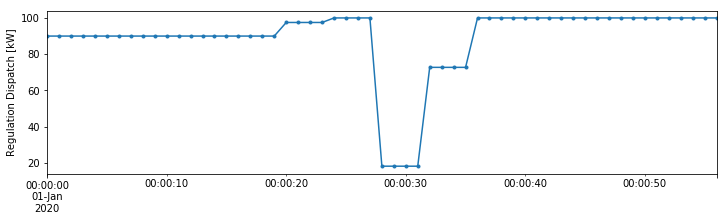

In [9]:
# Run for one hour
length = 60*60

# Setup dispatcher
dispatch = dispatcher(length=length, seed=seed)

# Print first 60 seconds
res = pd.DataFrame()
for ts in range(0, 60, dispatch.step):
    dp = dispatch.do_step()
    res.loc[dp[0], 'Dispatch [kW]'] = dp[1]
    print('Timestep [s]:', ts, '\tDispatch timestep [s]', dp[0], '\tDispatch power [kW]', dp[1])
    
# Prepare results and make plot
res.index = [pd.to_datetime('2020-01-01')+pd.DateOffset(seconds=ix) for ix in res.index]
res = res.resample('1S').ffill()
ax = res.plot(legend=False, figsize=(12,3), marker='.')
ax.set_ylabel('Regulation Dispatch [kW]')
plt.show()

### Batch Mode

Time [s]
0      90.00
4      90.00
8      90.00
12     90.00
16     90.00
20     97.50
24    100.00
28     18.25
32     72.75
36    100.00
40    100.00
44    100.00
48    100.00
52    100.00
56    100.00
60    100.00
Name: Dispatch [kW], dtype: float64


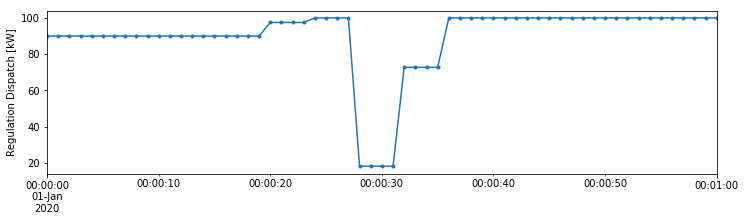

In [10]:
# Setup dispatcher
dispatch = dispatcher(length=length, seed=seed)
res = dispatch.get_sequence()
# Print first 60 seconds
print(res.loc[:60])

# Make plot
res = res.loc[:60]
res.index = [pd.to_datetime('2020-01-01')+pd.DateOffset(seconds=ix) for ix in res.index]
res = res.resample('1S').ffill()
ax = res.plot(legend=False, figsize=(12,3), marker='.')
ax.set_ylabel('Regulation Dispatch [kW]')
plt.show()

### Long Series

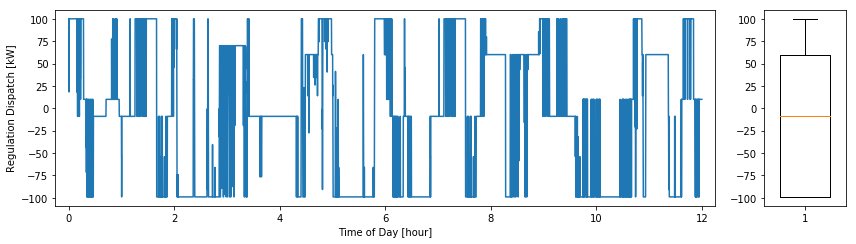

In [11]:
# Generate 12 hours of dispatch
dispatch = dispatcher(length=12*60*60, seed=seed)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 3.5), sharex=False, gridspec_kw={'width_ratios':[8, 1]})
axs = axs.ravel()
axs[0].plot(dispatch.get_sequence(timestamp='hour'))
axs[0].set_xlim(-0.25, 12.25)
axs[0].set_ylabel('Regulation Dispatch [kW]')
axs[0].set_xlabel('Time of Day [hour]')
axs[1].boxplot(dispatch.get_sequence(timestamp='hour'), widths=0.6)
plt.tight_layout()
plt.savefig(os.path.join(os.path.dirname(root), 'documentation', 'result_example.jpg'), dpi=600)
plt.show()